# Detect hapiness 

This notebook is based on the programming assignment of deeplearning.ai, course Convolutional Neural Networks, week Deep convolutional models case studies

We will build an algorithm that recognizes whether the person in a picture is happy or not.

## Learning objectives

- Application of Convolutional Neural Networks in TensorFlow
- Apply Batch Normalization
- Use of Adam optimizer 
- Use of GPU for the training of the model

In [2]:
import numpy as np
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import time
import math
import h5py
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

1.14.0


In [3]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [6]:
def build_inputs():
    
    inputs_ = tf.placeholder(tf.float32,[None,64,64,3],name='inputs_')
    targets_ = tf.placeholder(tf.float32,[None,1], name='targets_')
    training = tf.placeholder_with_default(False, shape=(), name='training')
    
    return inputs_, targets_, training

In [7]:
def build_loss(logits, targets):
        
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))

    return loss

In [8]:
def build_optimizer(loss, learning_rate):
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer

In [9]:
class HappyModel:
    
    def __init__(self, learning_rate):
    
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs_, self.targets_, self.training = build_inputs()
        
        # Zero-Padding
        paddings = tf.constant([[0, 0], [3, 3,], [3, 3], [0, 0]])
        self.X = tf.pad(self.inputs_, paddings, "CONSTANT")
        
        # CONV -> BN -> RELU Block applied to X
        strides = 1        
        self.X = tf.layers.conv2d(self.X, 32, kernel_size = [7, 7], strides = [strides, strides],
                             padding='VALID',name = 'conv0')
        self.X = tf.layers.batch_normalization(self.X, training=self.training, name = 'bn0')
        self.X = tf.nn.relu(self.X)
        
        # MAXPOOL
        self.X = tf.nn.max_pool(self.X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
        self.X = tf.contrib.layers.flatten(self.X)
        self.X = tf.contrib.layers.fully_connected(self.X, 1, activation_fn=None)
        self.prediction = tf.nn.sigmoid(self.X) 
        
        self.loss = build_loss(self.X, self.targets_)
        self.optimizer = build_optimizer(self.loss, learning_rate)
        
        correct_prediction = tf.equal(tf.round(self.prediction), self.targets_)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        self.acc, self.acc_op = tf.metrics.accuracy(labels=self.targets_, 
                                  predictions=tf.round(self.prediction))

In [10]:
batch_size = 16
mini_batch_size = 16
learning_rate = 0.001

### Load the dataset

In [11]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.


Y_train = tf.transpose(Y_train_orig)
Y_test = tf.transpose(Y_test_orig)

with tf.Session(config=config) as sess:
    Y_train,Y_test = sess.run([Y_train,Y_test])
    
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


In [12]:
tf.reset_default_graph()
epochs = 50
model = HappyModel(learning_rate = learning_rate)
extra_graphkeys_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

train_acc_mean = []

with tf.Session(config=config) as sess:
    saver = tf.train.Saver() 
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    #start_time=time.time()
    for e in range(epochs):
        train_acc = []
        train_acc_v2 = []
        iteration = 1
         
        for (x, y) in random_mini_batches(X_train, Y_train, mini_batch_size = mini_batch_size, seed = 0):
            feed = {model.inputs_: x,
                   model.targets_: y,
                   model.training: True}

            batch_loss, batch_accuracy, batch_acc, batch_acc_op,_, _= sess.run([model.loss, model.accuracy,
                                                      model.acc, model.acc_op,
                                                      model.optimizer ,extra_graphkeys_update_ops],
                                 feed_dict=feed)
            
            train_acc.append(batch_accuracy)
            train_acc_v2.append(batch_acc_op)
            if iteration%5==0:
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(batch_loss),
                      "Train accuracy: {:.4f}".format(batch_acc_op)
                     )
                     
                
            iteration +=1
    
    #duration=time.time()-start_time
    #print("duration: {:.1f} sec".format(duration))
        print("Train accuracy (mean): {:.4f}".format(np.mean(train_acc_v2)))
        train_acc_mean.append(np.mean(train_acc_v2))
    saver.save(sess, "checkpoints/HappyModel.ckpt")

W0812 22:27:52.513848 29180 deprecation.py:323] From <ipython-input-9-5c64e489e3d6>:17: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0812 22:27:52.516843 29180 deprecation.py:506] From C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0812 22:27:52.673450 29180 deprecation.py:323] From <ipython-input-9-5c64e489e3d6>:18: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.co

Epoch: 1/50 Iteration: 5 Train loss: 4.883 Train accuracy: 0.5250
Epoch: 1/50 Iteration: 10 Train loss: 2.073 Train accuracy: 0.5562
Epoch: 1/50 Iteration: 15 Train loss: 2.360 Train accuracy: 0.5792
Epoch: 1/50 Iteration: 20 Train loss: 3.234 Train accuracy: 0.5875
Epoch: 1/50 Iteration: 25 Train loss: 1.026 Train accuracy: 0.6075
Epoch: 1/50 Iteration: 30 Train loss: 0.501 Train accuracy: 0.6313
Epoch: 1/50 Iteration: 35 Train loss: 0.326 Train accuracy: 0.6571
Train accuracy (mean): 0.5944
Epoch: 2/50 Iteration: 5 Train loss: 0.254 Train accuracy: 0.6779
Epoch: 2/50 Iteration: 10 Train loss: 0.265 Train accuracy: 0.6921
Epoch: 2/50 Iteration: 15 Train loss: 0.190 Train accuracy: 0.7071
Epoch: 2/50 Iteration: 20 Train loss: 0.454 Train accuracy: 0.7217
Epoch: 2/50 Iteration: 25 Train loss: 0.092 Train accuracy: 0.7360
Epoch: 2/50 Iteration: 30 Train loss: 0.070 Train accuracy: 0.7500
Epoch: 2/50 Iteration: 35 Train loss: 0.201 Train accuracy: 0.7612
Train accuracy (mean): 0.7190
Epoc

Epoch: 17/50 Iteration: 35 Train loss: 0.053 Train accuracy: 0.9215
Train accuracy (mean): 0.9207
Epoch: 18/50 Iteration: 5 Train loss: 1.770 Train accuracy: 0.9209
Epoch: 18/50 Iteration: 10 Train loss: 0.504 Train accuracy: 0.9211
Epoch: 18/50 Iteration: 15 Train loss: 0.002 Train accuracy: 0.9214
Epoch: 18/50 Iteration: 20 Train loss: 0.796 Train accuracy: 0.9213
Epoch: 18/50 Iteration: 25 Train loss: 0.219 Train accuracy: 0.9214
Epoch: 18/50 Iteration: 30 Train loss: 0.009 Train accuracy: 0.9219
Epoch: 18/50 Iteration: 35 Train loss: 0.001 Train accuracy: 0.9219
Train accuracy (mean): 0.9215
Epoch: 19/50 Iteration: 5 Train loss: 0.052 Train accuracy: 0.9222
Epoch: 19/50 Iteration: 10 Train loss: 0.044 Train accuracy: 0.9222
Epoch: 19/50 Iteration: 15 Train loss: 0.125 Train accuracy: 0.9220
Epoch: 19/50 Iteration: 20 Train loss: 0.745 Train accuracy: 0.9219
Epoch: 19/50 Iteration: 25 Train loss: 0.011 Train accuracy: 0.9223
Epoch: 19/50 Iteration: 30 Train loss: 0.000 Train accurac

Epoch: 34/50 Iteration: 20 Train loss: 0.011 Train accuracy: 0.9482
Epoch: 34/50 Iteration: 25 Train loss: 0.001 Train accuracy: 0.9484
Epoch: 34/50 Iteration: 30 Train loss: 0.004 Train accuracy: 0.9486
Epoch: 34/50 Iteration: 35 Train loss: 0.000 Train accuracy: 0.9487
Train accuracy (mean): 0.9482
Epoch: 35/50 Iteration: 5 Train loss: 0.011 Train accuracy: 0.9488
Epoch: 35/50 Iteration: 10 Train loss: 0.027 Train accuracy: 0.9489
Epoch: 35/50 Iteration: 15 Train loss: 0.029 Train accuracy: 0.9491
Epoch: 35/50 Iteration: 20 Train loss: 0.033 Train accuracy: 0.9493
Epoch: 35/50 Iteration: 25 Train loss: 0.002 Train accuracy: 0.9494
Epoch: 35/50 Iteration: 30 Train loss: 0.103 Train accuracy: 0.9495
Epoch: 35/50 Iteration: 35 Train loss: 0.003 Train accuracy: 0.9497
Train accuracy (mean): 0.9492
Epoch: 36/50 Iteration: 5 Train loss: 0.002 Train accuracy: 0.9499
Epoch: 36/50 Iteration: 10 Train loss: 0.005 Train accuracy: 0.9499
Epoch: 36/50 Iteration: 15 Train loss: 0.003 Train accurac

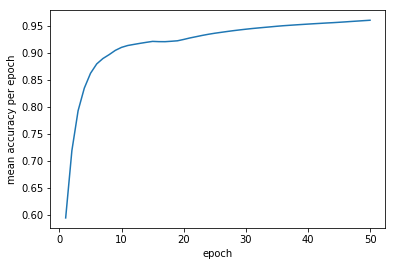

In [13]:
plt.plot(np.arange(1,epochs+1), train_acc_mean)
plt.ylabel('mean accuracy per epoch')
plt.xlabel('epoch')
plt.show()

In [14]:
# this part calculates the number of trainable parameters

model = HappyModel(learning_rate = learning_rate)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())

    total_parameters = 0
    for variable in tf.trainable_variables():
        print(variable)
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        print('shape of weight matrix: ',shape)
        #print(len(shape))
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim.value
        print('number of trainable parameters: ',variable_parameters)
        print('------------------------------')
        total_parameters += variable_parameters
    print('total number of trainable parameters: ',total_parameters)

# this part calculates the number of all the  parameters
    total_parameters = 0
    for variable in tf.all_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    print('total number of parameters: ',total_parameters)

W0812 22:28:22.844669 29180 deprecation.py:323] From <ipython-input-14-011611f3bf71>:26: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


<tf.Variable 'conv0/kernel:0' shape=(7, 7, 3, 32) dtype=float32_ref>
shape of weight matrix:  (7, 7, 3, 32)
number of trainable parameters:  4704
------------------------------
<tf.Variable 'conv0/bias:0' shape=(32,) dtype=float32_ref>
shape of weight matrix:  (32,)
number of trainable parameters:  32
------------------------------
<tf.Variable 'bn0/gamma:0' shape=(32,) dtype=float32_ref>
shape of weight matrix:  (32,)
number of trainable parameters:  32
------------------------------
<tf.Variable 'bn0/beta:0' shape=(32,) dtype=float32_ref>
shape of weight matrix:  (32,)
number of trainable parameters:  32
------------------------------
<tf.Variable 'fully_connected/weights:0' shape=(32768, 1) dtype=float32_ref>
shape of weight matrix:  (32768, 1)
number of trainable parameters:  32768
------------------------------
<tf.Variable 'fully_connected/biases:0' shape=(1,) dtype=float32_ref>
shape of weight matrix:  (1,)
number of trainable parameters:  1
------------------------------
total 

## Testing

In [15]:
tf.reset_default_graph()
model = HappyModel(learning_rate = learning_rate)

test_acc = []
test_acc_v2 = []

with tf.Session(config=config) as sess: 
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sess.run(tf.local_variables_initializer())
    
    iteration = 1
    #for (x, y) in get_batches(X_test, Y_test, batch_size):
    for (x, y) in random_mini_batches(X_test, Y_test, mini_batch_size = mini_batch_size, seed = 0):
        feed = {model.inputs_: x,
                   model.targets_: y,
                   model.training: False}


        batch_loss, batch_accuracy, batch_acc, batch_acc_op = sess.run([model.loss, model.accuracy,
                                                                       model.acc, model.acc_op],
                                 feed_dict=feed)
            
        test_acc.append(batch_accuracy)
        test_acc_v2.append(batch_acc_op)
        
        if iteration%1==0:
            print("Iteration: {}".format(iteration),
                      "Test loss: {:.3f}".format(batch_loss),
                      "Test accuracy: {:.4f}".format(batch_acc_op)
                     )
                     
                
        iteration +=1

    print("Test accuracy (mean): {:.4f} ".format(np.mean(test_acc_v2)))

W0812 22:28:24.891274 29180 deprecation.py:323] From C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Iteration: 1 Test loss: 0.114 Test accuracy: 0.9375
Iteration: 2 Test loss: 0.041 Test accuracy: 0.9688
Iteration: 3 Test loss: 0.121 Test accuracy: 0.9583
Iteration: 4 Test loss: 0.000 Test accuracy: 0.9688
Iteration: 5 Test loss: 0.044 Test accuracy: 0.9750
Iteration: 6 Test loss: 0.160 Test accuracy: 0.9688
Iteration: 7 Test loss: 0.060 Test accuracy: 0.9732
Iteration: 8 Test loss: 0.276 Test accuracy: 0.9609
Iteration: 9 Test loss: 0.105 Test accuracy: 0.9583
Iteration: 10 Test loss: 0.000 Test accuracy: 0.9600
Test accuracy (mean): 0.9630 
